In [33]:
import matplotlib.pyplot as plt
from utils import *
from einops import rearrange
from omegaconf import OmegaConf
from utils.utils_plot import plot_model,plot_shot
import  torch
import  numpy as np
from utils import make_and_load_model,make_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 设置config路径

In [34]:
config_path = "./config/template_he.yaml"
cfg = OmegaConf.load(config_path)

In [35]:
i = 4
cfg.generate_par.train_log_path = f"/data/yibiao/nn_loss/experiments/he/log/train_unet_{i}.hdf5"                                                                 #训练阶段的过程hdf5文件
cfg.generate_par.inversion_log_path =  f"/data/yibiao/nn_loss/experiments/he/log/inversion_unet_{i}.hdf5"                                                        #反演阶段的过程hdf5文件
cfg.generate_par.checkpoint_path = f"/data/yibiao/nn_loss/experiments/he/log/model_unet_{i}.pt"

# 可视化训练阶段损失

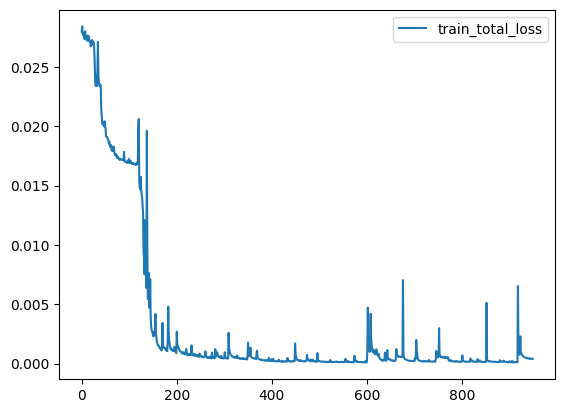

In [36]:
if cfg.generate_par.type == "FWI":
    pass
elif cfg.generate_par.type in ["UNet","CAE",]:
    train_log_path = cfg.generate_par.train_log_path
    with h5py.File(train_log_path,"r") as f:
        data = f["train_total_loss"][50:]
        plt.plot(data, label="train_total_loss")
        plt.legend()


# 可视化自编码器效果

模型已经成功加载。


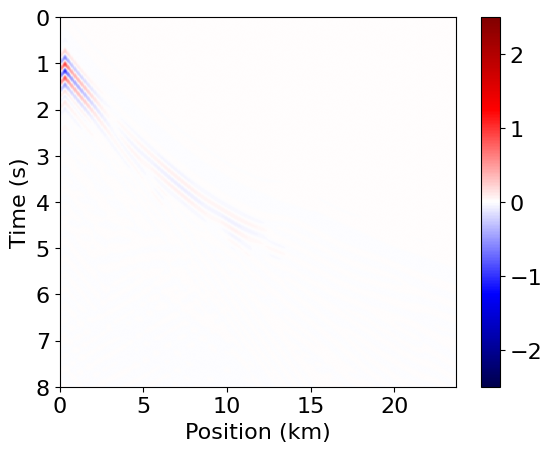

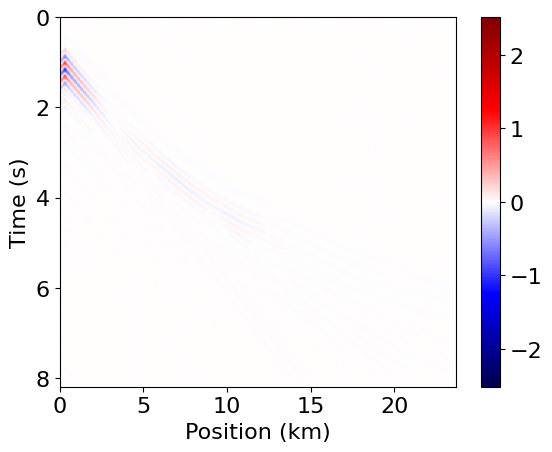

In [37]:
shot_index = 0
scale = 0.4

def norm_data(signal,data_norm):
    if data_norm is None:
        return  signal
    elif data_norm == "shot_norm":
        return signal / (torch.max(torch.abs(signal)) + 1e-5)
    elif data_norm == "receiver_norm":
        max_val, _ = torch.max(torch.abs(signal), dim=-1, keepdim=True)
        return signal / (max_val + 1e-5)


model = make_and_load_model(cfg)
model.eval()
obs_signal = np.load(cfg.generate_par.obs_signal_path)[shot_index,:,:]
obs_signal = norm_data(torch.tensor(obs_signal),cfg.generate_par.data_norm).numpy()
input_obs_signal = rearrange(torch.from_numpy(obs_signal).float().to(device),"r t -> r 1 t")
features = model.encoder(input_obs_signal)["features"]
output_obs_signal = model.forward(input_obs_signal)["re_signal"]
input_obs_signal = rearrange(input_obs_signal,"r 1 t -> r t").detach().cpu().numpy()
re_obs_signal = rearrange(output_obs_signal,"r 1 t -> r t").detach().cpu().numpy()


plot_shot(input_obs_signal.T, cfg.forward_par.dt, cfg.forward_par.grid_spacing, title='', pclip=1.0, scale=scale)
plot_shot(re_obs_signal.T, cfg.forward_par.dt, cfg.forward_par.grid_spacing, title='', pclip=1.0, scale=scale)


# 可视化特征图

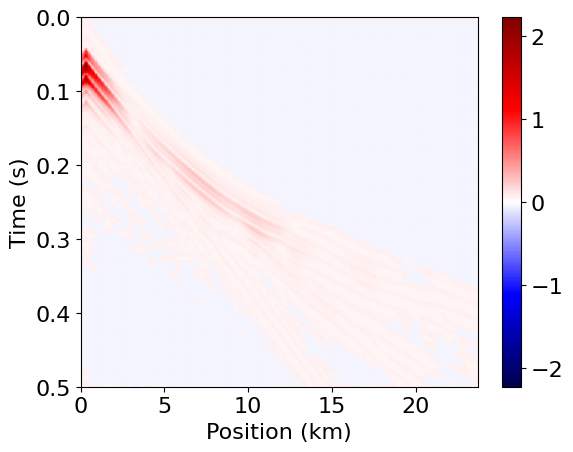

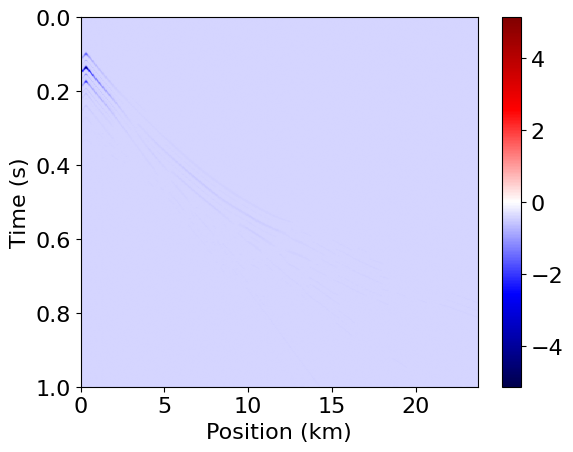

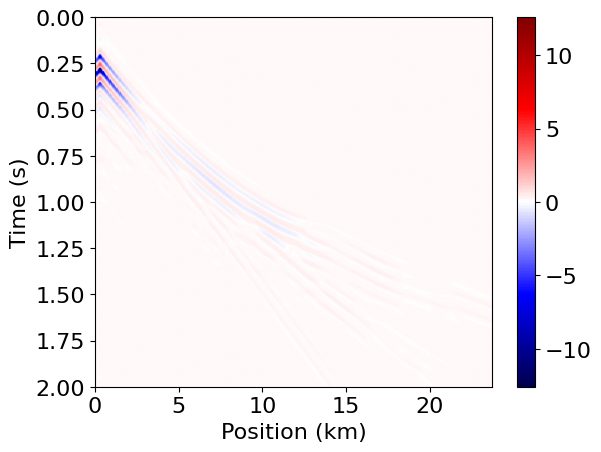

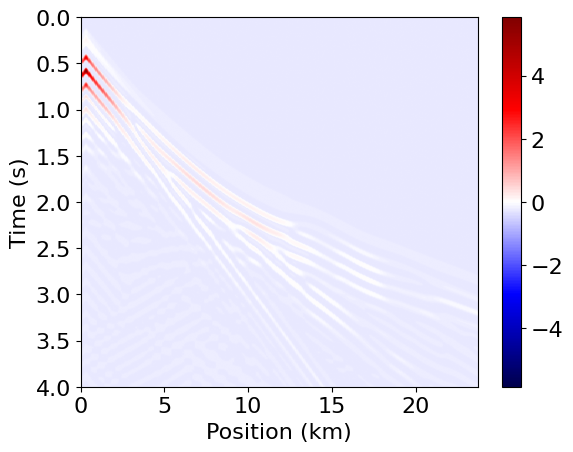

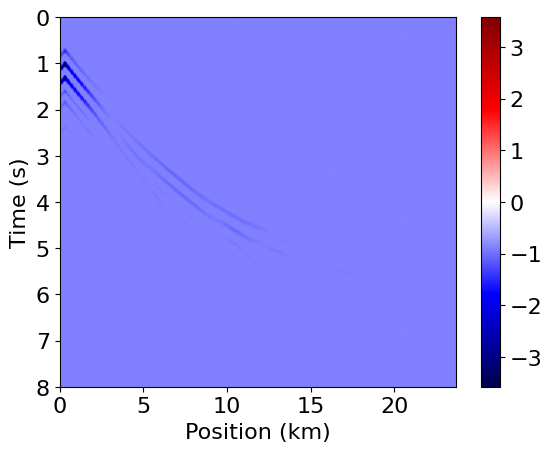

In [38]:
scale = 1
for feature in features:
    feature = rearrange(feature,"r 1 t -> r t").detach().cpu().numpy()
    plot_shot(feature.T, cfg.forward_par.dt, cfg.forward_par.grid_spacing, title='', pclip=1.0, scale=scale)

# 可视化反演阶段损失

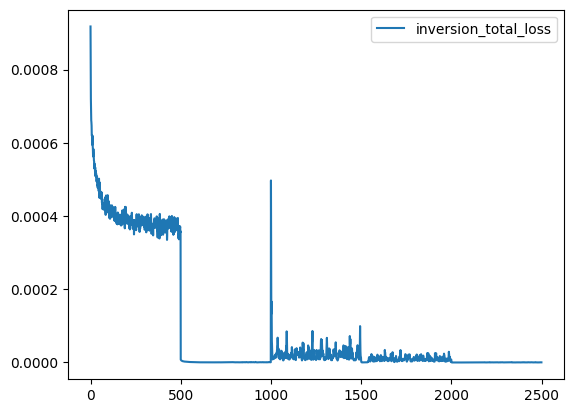

In [39]:
inversion_log_path = cfg.generate_par.inversion_log_path
with h5py.File(inversion_log_path,"r") as f:
        data = f["inversion_total_loss"][:]
        plt.plot(data, label="inversion_total_loss")
        plt.legend()


# 可视化反演结果

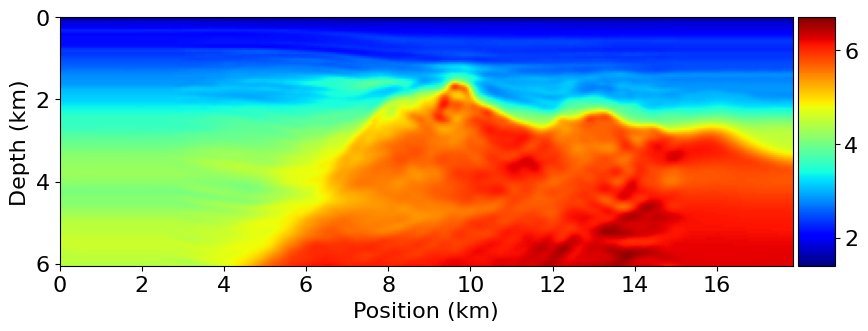

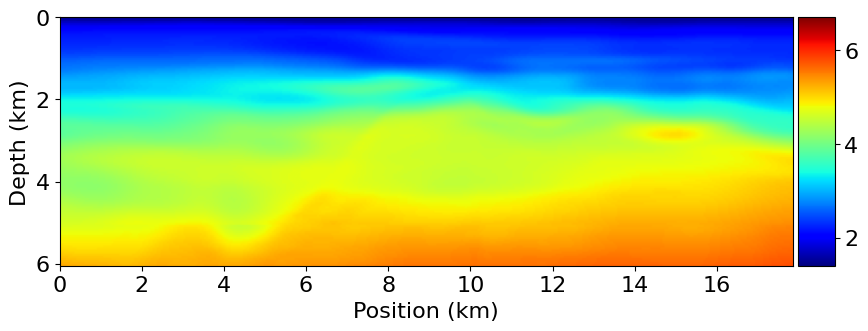

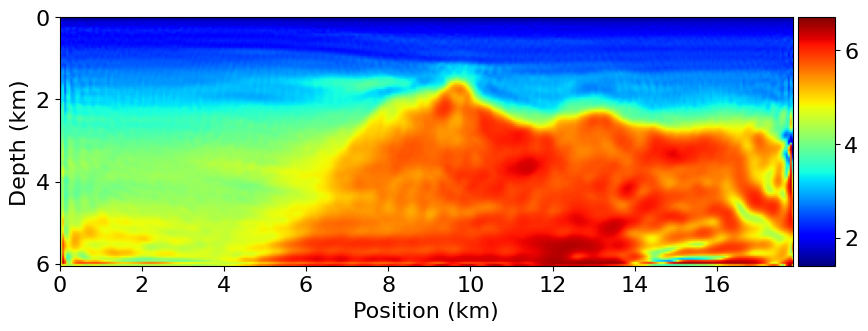

In [40]:
aspect = 1
figsize = (10,10)

cfg.generate_par.inversion_log_path =  f"/data/yibiao/nn_loss/experiments/he/log/inversion_unet_{i}.hdf5"

vp_true = np.load(cfg.forward_par.vp_true_path)
vp_init = np.load(cfg.forward_par.vp_init_path)
with h5py.File(cfg.generate_par.inversion_log_path,"r") as f:
    vp_inv = f["vp_inv"][-1]

plot_model(vp_true.T, cfg.forward_par.grid_spacing, cfg.forward_par.min_vel/1000, cfg.forward_par.max_vel/1000, title='',aspect = aspect,figsize=figsize)
plot_model(vp_init.T, cfg.forward_par.grid_spacing, cfg.forward_par.min_vel/1000, cfg.forward_par.max_vel/1000, title='',aspect = aspect,figsize=figsize)
plot_model(vp_inv.T, cfg.forward_par.grid_spacing, cfg.forward_par.min_vel/1000, cfg.forward_par.max_vel/1000, title='',aspect = aspect,figsize=figsize)
